In [15]:
#dataset = 'hatespeech'
dataset = 'businessnews'

In [16]:
import os
import pandas as pd
import random
import numpy as np
import re

In [17]:
SEED = 1
# REPEATABILITY
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
seed_everything()

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x: # comparison makes faster
            x = x.replace(punct, f' {punct} ')
    return x

quotes = ['″', '′', '"'] # apostrophe "'"
def mark_quotes(x):
    x = str(x)
    for quote in quotes:
        if quote in x: # comparison makes faster
            x = x.replace(quote, f'quote')
    return x

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    mention_regex = '@[\w\-]+'
    
    #add #, mention, e.g. &#8120     
    mention_regex2  =   '&#[0-9]*' 
    
    
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, ' URL ', parsed_text)
    parsed_text = re.sub(mention_regex, ' MENTION', parsed_text)
    parsed_text = re.sub(mention_regex2, ' MENTION', parsed_text)    
    return parsed_text


def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    
    # *needed to be removed or outputs a list of letters
    #tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    tweet = " ".join(re.split("[^a-zA-Z.,!?]", tweet.lower())).strip()  
    #tweet = " ".join(re.split(r'\s+', tweet.lower())).strip()
    return tweet.split()

In [18]:
current = os.getcwd()
basefolder = current + '/dataset_'+ dataset+'/'
datafolder = basefolder + 'data/'  # for example /dataset_businessnews/data/
print(datafolder)

infolder =  basefolder + 'input/'
outfolder = basefolder + 'output/'

/home/max/git/modelcompare/dataset_businessnews/data/


In [19]:
datafile = datafolder + 'labeled_data.csv' # one with ENT tag added
datafile

'/home/max/git/modelcompare/dataset_businessnews/data/labeled_data.csv'

In [20]:
mydata = pd.read_csv(datafile, header=None, names=['label', 'text']) # hatespeech data, header exists
mydata.head(4)

,label,text
0,2,Tesla is Now Officially More Than Just About C...
1,4,Health insurer ENTITY Aetna's quarterly profit...
2,4,The Capital Hotel sold to American hospitality...
3,0,German prosecutors investigate ENTITY Volkswag...


In [21]:
len(mydata)

# business news 19718
# hatespeech  24783


19718

In [22]:
df = mydata

In [23]:
import seaborn as sns
sns.set()

#sns.axes_style("whitegrid")
sns.set_style("whitegrid")


#### Truncate - optional

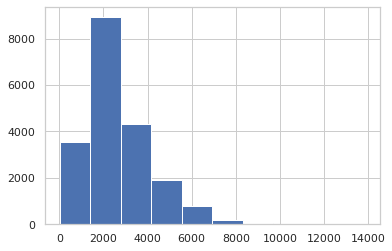

In [24]:
df['text'].map(len).hist()

In [25]:
longest = df['text'].map(len).max()
longest

# Longest is 13.8k characters. From plot we see that truncating to 6k-8k characters only cuts away minimally.

13825

In [26]:
maxlen = 5000
df['text'] = df.apply(lambda row: row['text'][0:maxlen], axis=1 )
df['text'].map(len).max()

5000

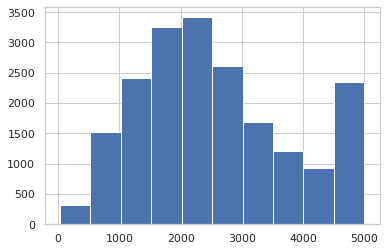

In [27]:
df['text'].map(len).hist()

In [28]:
# Randomize data
np.random.seed(SEED)
trn_idx = np.random.permutation(len(df))
df = df.iloc[trn_idx]

In [29]:
df

,label,text
8862,3,Praxair Signs Long-Term U.S. Gulf Coast Hydrog...
3261,0,"ENTITY Twitter, Inc. Posts Flat U.S. Monthly A..."
4135,0,What Impact Will The DuPont Settlement Have On...
6394,1,ENTITY Coca-Cola profits in line with estimate...
10366,4,ENTITY Heineken posts 9.9% rise in annual earn...
...,...,...
10955,3,American International Group Inc. Increases Po...
17289,3,Top automakers fund charging sites to boost el...
5192,1,Carrier incentives stir debate over 'rewarding...
12172,4,ENTITY Netflix posts better-than-expected quar...


In [30]:
# Preprocess

### Write data with minimal preprosessing out to one file

In [31]:
# if need, first create input/ and output/

df.to_csv(basefolder+'input/alldata.csv',sep='\t', index = False, header = False)

In [32]:
# add index as own column to keep track of each items id
df = df.reset_index()

### Train,dev,test split by strafity (keep ratio of classes)

In [33]:
from sklearn.model_selection import train_test_split

seed_everything(seed=1)

size = len(df)
dev_size = 3000
test_size = 3000


# slice out the test set
remaining, test = train_test_split(df, stratify=df['label'], test_size=test_size)
print(len(test))
print(len(remaining))
# slice out train and dev
train, dev = train_test_split(remaining, stratify=remaining['label'], test_size=dev_size)


#train = df[0 : size - test_size - dev_size]
#dev = df[size - test_size - dev_size : size-test_size]
#test = df[size-test_size : size]


#train.to_json('input/train.json', orient='records', lines=True)
#val.to_json('input/val.json', orient='records', lines=True)
#test.to_json('input/test.json', orient='records', lines=True)

train.to_csv(basefolder+'input/train.csv',sep='\t', index = False, header = False)
dev.to_csv(basefolder+'input/dev.csv'  ,sep='\t', index = False, header = False)
test.to_csv(basefolder+'input/test.csv',sep='\t', index = False, header = False)

3000
16718


In [34]:
len(train)

13718

In [35]:
len(dev)

3000

In [36]:
len(test)

3000

In [37]:
test.head()

,index,label,text
7551,14177,0,ENTITY Lufthansa pilot 'strike' forces over 18...
5993,2954,0,"ENTITY Tiffany, & CO is sliding as its CEO res..."
14650,18362,3,ENTITY Tesla will begin Model 3 production tri...
1663,1005,0,ENTITY The Limited to Close all Brick-and-Mort...
18303,5777,1,ENTITY Samsung Electronics says battery caused...


### print info about data

In [38]:
# Counts, Majority

# 0 - very negative
# 1 - negative
# 2 - neutral
# 3 - positive
# 4 - very positive
# (removed: 5 - contradiction between annotators)

from collections import Counter
c = Counter(df['label'])
c


Counter({3: 6250, 0: 5743, 1: 3471, 4: 3877, 2: 377})

In [39]:
# Majority class by 0.32 is class 3 - positive
# 2nd is class 0 by 0.29, very negative

from collections import Counter
c = Counter(df['label'])

s = sum(c.values())
for elem, count in c.items():
      print(elem, count / s)

3 0.31696926665990466
0 0.2912567197484532
1 0.17603205193224464
4 0.19662237549447206
2 0.01911958616492545


In [40]:
# use seaborn background for plot
import seaborn as sns
sns.set()

#sns.axes_style("whitegrid")
sns.set_style("whitegrid")

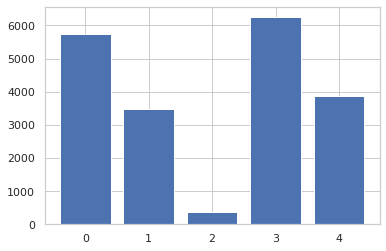

In [41]:
import collections
import matplotlib.pyplot as plt

plt.bar(c.keys(), c.values())
plt.show()

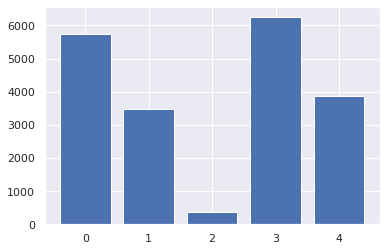

In [42]:
sns.set_style("darkgrid")

import collections
import matplotlib.pyplot as plt

#sns.set_style("ticks")
#sns.set()
plt.bar(c.keys(), c.values())
plt.show()